# Import libraries

In [1]:
from tabulate import tabulate
import sys, os

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql.functions import unix_timestamp, to_timestamp, round, log, col, isnan, when, count, concat, lit, substring, udf, desc, hour
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder 
from pyspark.ml.evaluation import RegressionEvaluator



**Arguments from command line**

In [2]:
print("\nArguments passed:", end = " ")
for i in range(1, len(sys.argv)):
    print(sys.argv[i], end = " ")


Arguments passed: -f C:\Users\Ofeucor\AppData\Roaming\jupyter\runtime\kernel-eae056e9-cc30-485c-85ea-78e52d210c7f.json 

*python app.py --path ./Data*

In [3]:
if '--path' in sys.argv:
    dir_path = sys.argv[sys.argv.index('--path')+1]
else:
    print('Add the argument "--path" followed by the address where the data is located.')
    exit(-1)

Add the argument "--path" followed by the address where the data is located.


**We create our app**

In [4]:
spark = SparkSession.builder.appName("BigDataApp").getOrCreate()
spark.sparkContext

<SparkContext master=local[*] appName=BigDataApp>

# Loading the Data

**Create a schema for the DataFrame**

In [5]:
schema = StructType([
    StructField("Year",IntegerType(),nullable=True),
    StructField("Month",IntegerType(),nullable=True),
    StructField("DayofMonth",IntegerType(),nullable=True),
    StructField("DayOfWeek",IntegerType(),nullable=True),
    StructField("DepTime",IntegerType(),nullable=True),
    StructField("CRSDepTime",IntegerType(),nullable=True),
    StructField("ArrTime",IntegerType(),nullable=True),
    StructField("CRSArrTime",IntegerType(),nullable=True),
    StructField("UniqueCarrier",StringType(),nullable=True),
    StructField("FlightNum",IntegerType(),nullable=True),
    StructField("TailNum",StringType(),nullable=True),
    StructField("ActualElapsedTime",IntegerType(),nullable=True),
    StructField("CRSElapsedTime",IntegerType(),nullable=True),
    StructField("AirTime",IntegerType(),nullable=True),
    StructField("ArrDelay",IntegerType(),nullable=True),
    StructField("DepDelay",IntegerType(),nullable=True),
    StructField("Origin",StringType(),nullable=True),
    StructField("Dest",StringType(),nullable=True),
    StructField("Distance",IntegerType(),nullable=True),
    StructField("TaxiIn",IntegerType(),nullable=True),
    StructField("TaxiOut",IntegerType(),nullable=True),
    StructField("Cancelled",IntegerType(),nullable=True),
    StructField("CancellationCode",StringType(),nullable=True),
    StructField("Diverted",IntegerType(),nullable=True),
    StructField("CarrierDelay",IntegerType(),nullable=True),
    StructField("WeatherDelay",IntegerType(),nullable=True),
    StructField("NASDelay",IntegerType(),nullable=True),
    StructField("SecurityDelay",IntegerType(),nullable=True),
    StructField("LateAircraftDelay",IntegerType(),nullable=True)
])

**Load data into DataFrame**

In [6]:
arg = './resources/data/2008.csv.bz2'
dir_path = './resources/data'

if dir_path[-1] != '/':
    dir_path+='/'

In [7]:
files_path = []
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)) and path.endswith(".csv.bz2"):
        files_path.append(dir_path+path)
        
files_path#df1.union(df2)

['./resources/data/1987.csv.bz2',
 './resources/data/2000.csv.bz2',
 './resources/data/2008.csv.bz2']

In [8]:
df = spark.read.csv(path=files_path[0], schema=schema, header=True)

for f in files_path[1:]:
    df = df.union(spark.read.csv(path=f, schema=schema, header=True))
display(df.take(5))

[Row(Year=1987, Month=10, DayofMonth=14, DayOfWeek=3, DepTime=741, CRSDepTime=730, ArrTime=912, CRSArrTime=849, UniqueCarrier='PS', FlightNum=1451, TailNum='NA', ActualElapsedTime=91, CRSElapsedTime=79, AirTime=None, ArrDelay=23, DepDelay=11, Origin='SAN', Dest='SFO', Distance=447, TaxiIn=None, TaxiOut=None, Cancelled=0, CancellationCode='NA', Diverted=0, CarrierDelay=None, WeatherDelay=None, NASDelay=None, SecurityDelay=None, LateAircraftDelay=None),
 Row(Year=1987, Month=10, DayofMonth=15, DayOfWeek=4, DepTime=729, CRSDepTime=730, ArrTime=903, CRSArrTime=849, UniqueCarrier='PS', FlightNum=1451, TailNum='NA', ActualElapsedTime=94, CRSElapsedTime=79, AirTime=None, ArrDelay=14, DepDelay=-1, Origin='SAN', Dest='SFO', Distance=447, TaxiIn=None, TaxiOut=None, Cancelled=0, CancellationCode='NA', Diverted=0, CarrierDelay=None, WeatherDelay=None, NASDelay=None, SecurityDelay=None, LateAircraftDelay=None),
 Row(Year=1987, Month=10, DayofMonth=17, DayOfWeek=6, DepTime=741, CRSDepTime=730, ArrTi

**Remove forbidden variables**

In [9]:
df = df.drop("ArrTime").drop("ActualElapsedTime"
        ).drop("AirTime").drop("TaxiIn").drop("Diverted"
        ).drop("CarrierDelay").drop("WeatherDelay").drop("NASDelay"
        ).drop("SecurityDelay").drop("LateAircraftDelay")

In [10]:
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)



In [11]:
df.show(5, False)

+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+---------+----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiOut|Cancelled|CancellationCode|
+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+---------+----------------+
|1987|10   |14        |3        |741    |730       |849       |PS           |1451     |NA     |79            |23      |11      |SAN   |SFO |447     |null   |0        |NA              |
|1987|10   |15        |4        |729    |730       |849       |PS           |1451     |NA     |79            |14      |-1      |SAN   |SFO |447     |null   |0        |NA              |
|1987|10   |17        |6        |741    |730       |849       |PS          

# Analysis

In [12]:
(df.count(), len(df.columns))

(9384090, 19)

## Univariate analysis

In [13]:
df.columns

['Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'DepTime',
 'CRSDepTime',
 'CRSArrTime',
 'UniqueCarrier',
 'FlightNum',
 'TailNum',
 'CRSElapsedTime',
 'ArrDelay',
 'DepDelay',
 'Origin',
 'Dest',
 'Distance',
 'TaxiOut',
 'Cancelled',
 'CancellationCode']

In [14]:
numerics_col = [
 'Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'ArrDelay',
 'DepDelay',
 'Distance',
 'TaxiOut']

categorical_col = [
 'UniqueCarrier',
 'FlightNum',
 'TailNum',
 'Origin',
 'Dest',
 'Cancelled',
 'CancellationCode']

In [16]:
for c in categorical_col:
    print(df.groupBy(c).count().show())

+----+-------+
|Year|  count|
+----+-------+
|2008|2389217|
+----+-------+

None
+-----+------+
|Month| count|
+-----+------+
|    1|605765|
|    2|569236|
|    3|616090|
|    4|598126|
+-----+------+

None
+----------+-----+
|DayofMonth|count|
+----------+-----+
|        31|40905|
|        28|81974|
|        26|74226|
|        27|79527|
|        12|73690|
|        22|77730|
|         1|76749|
|        13|79091|
|         6|79879|
|        16|76898|
|         3|81108|
|        20|79565|
|         5|75303|
|        19|74270|
|        15|77716|
|         9|76023|
|        17|80508|
|         4|82101|
|         8|77320|
|        23|76860|
+----------+-----+
only showing top 20 rows

None
+---------+------+
|DayOfWeek| count|
+---------+------+
|        1|347984|
|        6|288097|
|        3|365560|
|        5|350566|
|        4|349831|
|        7|328237|
|        2|358942|
+---------+------+

None
+--------+-----+
|ArrDelay|count|
+--------+-----+
|     148|  584|
|     463|   10|
|     

In [95]:
for c in numerics_col:
    print(df.select(c).describe().show())

+-------+-------+
|summary|   Year|
+-------+-------+
|  count|2319115|
|   mean| 2008.0|
| stddev|    0.0|
|    min|   2008|
|    max|   2008|
+-------+-------+

None
+-------+------------------+
|summary|             Month|
+-------+------------------+
|  count|           2319115|
|   mean| 2.510822878554966|
| stddev|1.1234820066756623|
|    min|                 1|
|    max|                 4|
+-------+------------------+

None
+-------+------------------+
|summary|        DayofMonth|
+-------+------------------+
|  count|           2319115|
|   mean|15.696124599254457|
| stddev| 8.744862508072371|
|    min|                 1|
|    max|                31|
+-------+------------------+

None
+-------+------------------+
|summary|         DayOfWeek|
+-------+------------------+
|  count|           2319115|
|   mean| 3.915920081582845|
| stddev|1.9826417984380473|
|    min|                 1|
|    max|                 7|
+-------+------------------+

None
+-------+------------------+
|s

## Multivariate analysis

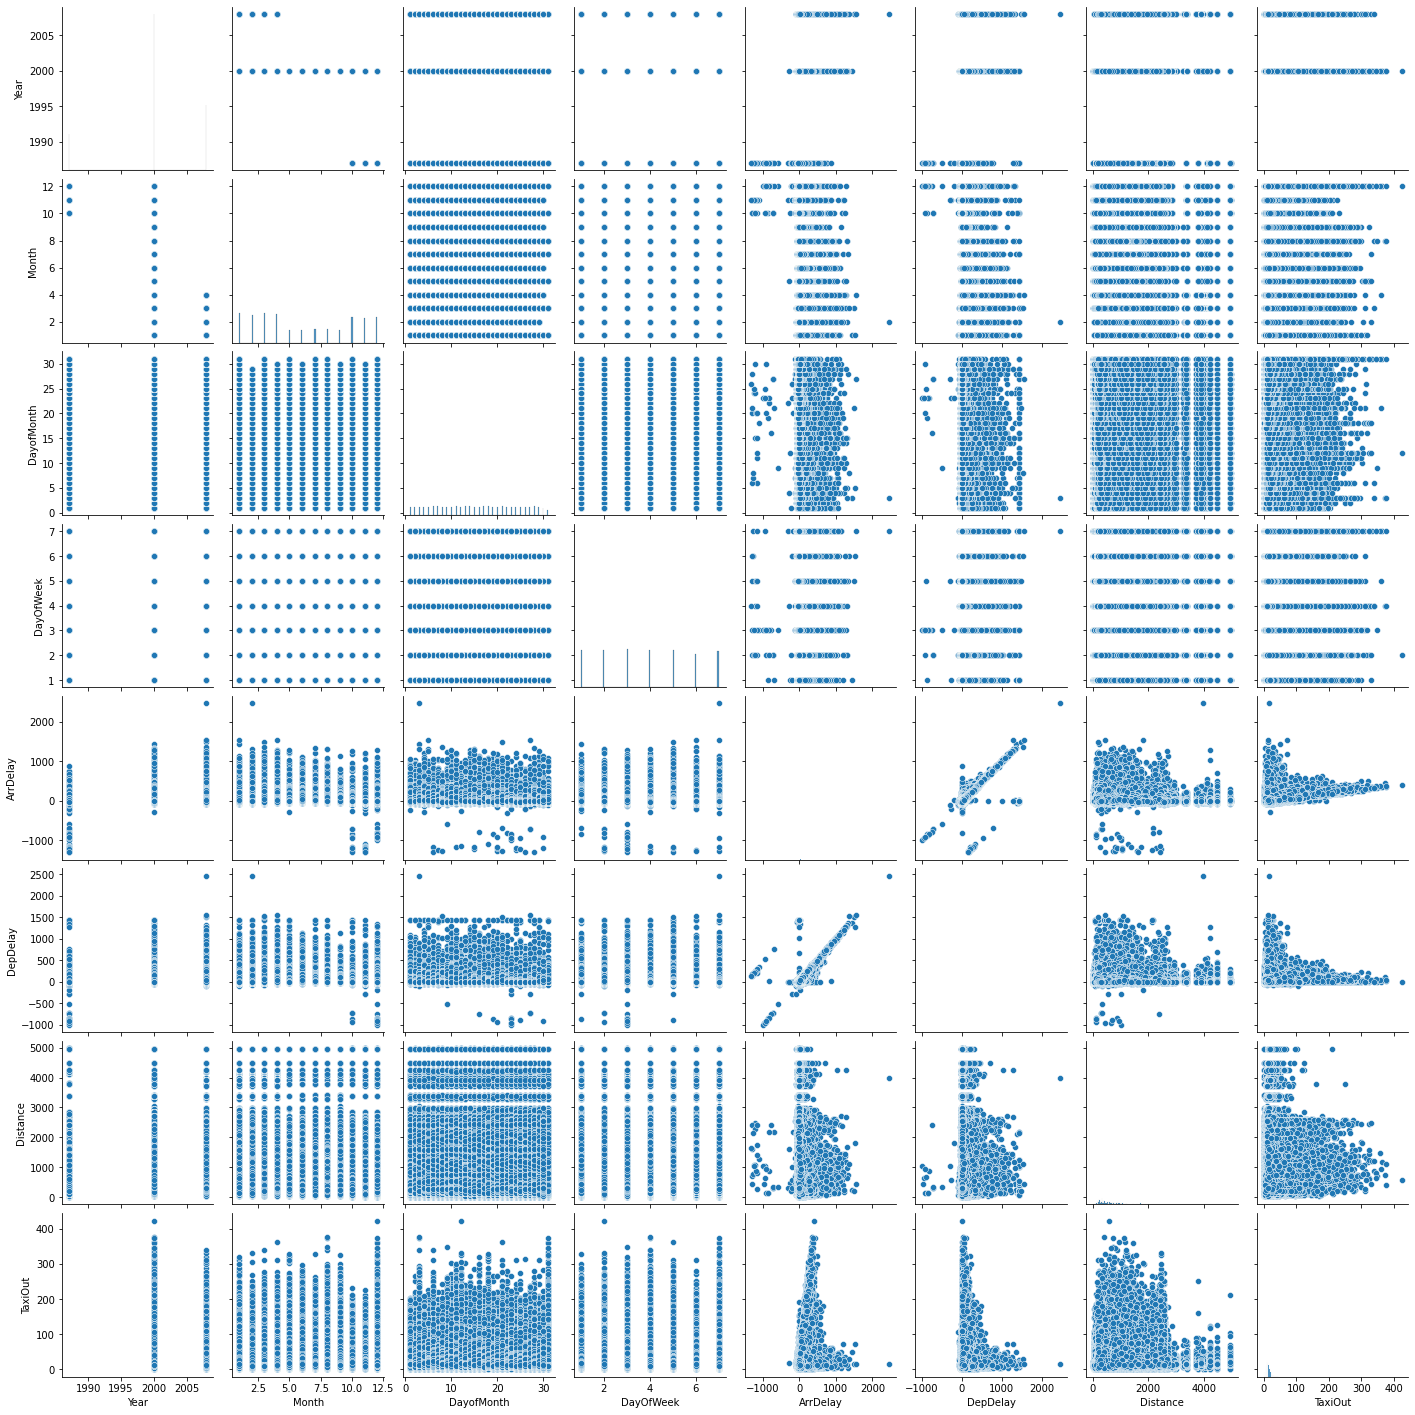

In [18]:
import seaborn as sns
import numpy as np

df_s, df_subset = df.randomSplit([.6,.4])


sns.pairplot(df_subset.select(numerics_col).toPandas())

In [19]:
df.stat.crosstab('Origin', 'UniqueCarrier').show()

+--------------------+---+-----+---+---+-----+----+----+---+---+---+---+-----+----+----+-----+-----+----+----+----+----+
|Origin_UniqueCarrier| 9E|   AA| AQ| AS|   B6|  CO|  DL| EV| F9| FL| HA|   MQ|  NW|  OH|   OO|   UA|  US|  WN|  XE|  YV|
+--------------------+---+-----+---+---+-----+----+----+---+---+---+---+-----+----+----+-----+-----+----+----+----+----+
|                 ROW|  0|    0|  0|  0|    0|   0|   0|  0|  0|  0|  0|  263|   0|   0|    0|    0|   0|   0|   0|   0|
|                 OAJ|  0|    0|  0|  0|    0|   0|   0|359|  0|  0|  0|    0|   0|   0|    0|    0|   0|   0|   0|   0|
|                 SYR| 54|    0|  0|  0|  751|   0|   0|452|  0|  0|  0|  500| 337| 524|  139|    0| 432|   0| 701| 360|
|                 ACY|  0|    0|  0|  0|    0|   0|   0|113|  0|  0|  0|    0|   0|   3|    0|    0|   0|   0|   0|   0|
|                 TYR|  0|    0|  0|  0|    0|   0|   0|  0|  0|  0|  0|  604|   0|   0|    0|    0|   0|   0|   0|   0|
|                 TUL|847|  992|

# Processing the Data

## Removing noise

**Remove duplicated rows**

In [12]:
df = df.distinct()

In [13]:
df.groupBy(df.columns).count().filter("count > 1").show()

+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+---------+----------------+-----+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiOut|Cancelled|CancellationCode|count|
+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+---------+----------------+-----+
+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+---------+----------------+-----+



**Remove instances of cancelled flights**

In [14]:
df.groupBy('Cancelled').count().show()

+---------+-------+
|Cancelled|  count|
+---------+-------+
|        1|  64442|
|        0|2324771|
+---------+-------+



In [15]:
df.groupBy('CancellationCode').count().show()

+----------------+-------+
|CancellationCode|  count|
+----------------+-------+
|            null|2324771|
|               B|  25744|
|               C|  12617|
|               A|  26075|
|               D|      6|
+----------------+-------+



In [16]:
df = df.filter(df.Cancelled == 0)

In [17]:
df = df.filter(df.CancellationCode.isNull())

**CancellationCode has more than 97% missing so it is removed**

In [18]:
df = df.drop('CancellationCode', 'Cancelled')

**Analyze missing values**

In [19]:
size=df.count()

In [21]:
print(tabulate([[c, df.filter(col(c).isNull()).count()/size] for c in df.columns], headers=['Name', 'Count %']))

Name                Count %
--------------  -----------
Year            0
Month           0
DayofMonth      0
DayOfWeek       0
DepTime         0
CRSDepTime      0
CRSArrTime      0
UniqueCarrier   0
FlightNum       0
TailNum         1.29045e-06
CRSElapsedTime  0.000123883
ArrDelay        0.00243207
DepDelay        0
Origin          0
Dest            0
Distance        0
TaxiOut         0


**TailNum and CRSElapsedTime can not be imputed from any other column, and ArrDelay is the target variable, but their number of missing values is not significant taking into account the total number, so the rows containing those missing values are removed**

In [20]:
df = df.na.drop()

In [21]:
(df.count(), len(df.columns))

(2319115, 17)

## !!!!!Date preprocess

In [22]:
df = df.withColumn(
    "Season", when((df.Month>2) & (df.Month<6), 1).when((df.Month>5) & (df.Month<9), 2
        ).when((df.Month>8) & (df.Month<12), 3).otherwise(4)
)
df.groupBy('Season').count().show()

+------+-------+
|Season|  count|
+------+-------+
|     1|1185064|
|     4|1134051|
+------+-------+



In [23]:
df = df.withColumn(
    "Date", F.date_format(F.expr("make_date(Year, Month, DayofMonth)"), "MM/dd/yyyy")
)

df.groupBy('Date').count().show()

+----------+-----+
|      Date|count|
+----------+-----+
|04/05/2008|16939|
|03/28/2008|20534|
|04/24/2008|20524|
|01/15/2008|19167|
|01/08/2008|19104|
|03/29/2008|17168|
|03/02/2008|19095|
|03/14/2008|20591|
|04/13/2008|19442|
|01/13/2008|18549|
|03/27/2008|19997|
|02/10/2008|18438|
|04/23/2008|20320|
|03/11/2008|19882|
|02/05/2008|18322|
|01/24/2008|19899|
|04/30/2008|20311|
|03/08/2008|15670|
|03/23/2008|19309|
|03/25/2008|19971|
+----------+-----+
only showing top 20 rows



**Check that DepDelay = DepTime - CRSDepTime**

In [24]:
df = df.withColumn("DepTimeNew", when(F.length(df.DepTime) == 3, concat(lit("0"),df.DepTime)) \
        .when(F.length(df.DepTime) == 2, concat(lit("00"),df.DepTime)) \
        .when(F.length(df.DepTime) == 1, concat(lit("000"),df.DepTime)) \
        .otherwise(df.DepTime))

In [25]:
df = df.withColumn("CRSDepTimeNew", when(F.length(df.CRSDepTime) == 3, concat(lit("0"),df.CRSDepTime)) \
        .when(F.length(df.CRSDepTime) == 2, concat(lit("00"),df.CRSDepTime)) \
        .when(F.length(df.CRSDepTime) == 1, concat(lit("000"),df.CRSDepTime)) \
        .otherwise(df.CRSDepTime))

In [26]:
df = df.withColumn("CRSArrTimeNew", when(F.length(df.CRSArrTime) == 3, concat(lit("0"),df.CRSArrTime)) \
        .when(F.length(df.CRSArrTime) == 2, concat(lit("00"),df.CRSArrTime)) \
        .when(F.length(df.CRSArrTime) == 1, concat(lit("000"),df.CRSArrTime)) \
        .otherwise(df.CRSArrTime))

In [27]:
df.select("DepTime","DepTimeNew","CRSDepTime","CRSDepTimeNew","CRSArrTime","CRSArrTimeNew").show()

+-------+----------+----------+-------------+----------+-------------+
|DepTime|DepTimeNew|CRSDepTime|CRSDepTimeNew|CRSArrTime|CRSArrTimeNew|
+-------+----------+----------+-------------+----------+-------------+
|   1215|      1215|      1220|         1220|      1324|         1324|
|   1540|      1540|      1409|         1409|      1711|         1711|
|   1835|      1835|      1755|         1755|      1845|         1845|
|    709|      0709|       655|         0655|       830|         0830|
|    700|      0700|       705|         0705|       825|         0825|
|    724|      0724|       737|         0737|       859|         0859|
|    738|      0738|       740|         0740|       835|         0835|
|    742|      0742|       745|         0745|       845|         0845|
|    852|      0852|       850|         0850|      1105|         1105|
|    905|      0905|       908|         0908|      1015|         1015|
|    930|      0930|       935|         0935|      1030|         1030|
|    9

In [28]:
df.select("DepTimeNew","CRSDepTimeNew","DepDelay").show()

+----------+-------------+--------+
|DepTimeNew|CRSDepTimeNew|DepDelay|
+----------+-------------+--------+
|      1215|         1220|      -5|
|      1540|         1409|      91|
|      1835|         1755|      40|
|      0709|         0655|      14|
|      0700|         0705|      -5|
|      0724|         0737|     -13|
|      0738|         0740|      -2|
|      0742|         0745|      -3|
|      0852|         0850|       2|
|      0905|         0908|      -3|
|      0930|         0935|      -5|
|      0940|         0940|       0|
|      1029|         1010|      19|
|      1037|         1040|      -3|
|      1051|         1040|      11|
|      1239|         1136|      63|
|      1259|         1300|      -1|
|      1325|         1315|      10|
|      1437|         1425|      12|
|      1435|         1436|      -1|
+----------+-------------+--------+
only showing top 20 rows



In [29]:
df = df.withColumn("CRSDepTimeNewHour", substring(df.CRSDepTimeNew, 1,2)) \
    .withColumn("CRSDepTimeNewMinute", substring(df.CRSDepTimeNew, 3,2)) \
    .withColumn("DepTimeNewHour", substring(df.DepTimeNew, 1,2)) \
    .withColumn("DepTimeNewMinute", substring(df.DepTimeNew, 3,2))

df = df.withColumn("CRSArrTimeNewHour", substring(df.CRSArrTimeNew, 1,2)) \
    .withColumn("CRSArrTimeNewMinute", substring(df.CRSArrTimeNew, 3,2))

In [30]:
df.select("CRSDepTimeNew","CRSDepTimeNewHour","CRSDepTimeNewMinute","DepTimeNew","DepTimeNewHour","DepTimeNewMinute").show()

+-------------+-----------------+-------------------+----------+--------------+----------------+
|CRSDepTimeNew|CRSDepTimeNewHour|CRSDepTimeNewMinute|DepTimeNew|DepTimeNewHour|DepTimeNewMinute|
+-------------+-----------------+-------------------+----------+--------------+----------------+
|         1220|               12|                 20|      1215|            12|              15|
|         1409|               14|                 09|      1540|            15|              40|
|         1755|               17|                 55|      1835|            18|              35|
|         0655|               06|                 55|      0709|            07|              09|
|         0705|               07|                 05|      0700|            07|              00|
|         0737|               07|                 37|      0724|            07|              24|
|         0740|               07|                 40|      0738|            07|              38|
|         0745|               

In [31]:
df = df.withColumn(
    "datetime",
    F.date_format(
        F.expr("make_timestamp(Year, Month, DayofMonth, CRSDepTimeNewHour, CRSDepTimeNewMinute, 0)"),
        "dd/MM/yyyy HH:mm"
    )
)
df_truncated = hour((round(unix_timestamp(to_timestamp(col("datetime"),"dd/MM/yyyy HH:mm"))/3600)*3600).cast("timestamp"))
df = df.withColumn("hourTimeCRSDep", df_truncated)

df = df.withColumn(
    "datetime",
    F.date_format(
        F.expr("make_timestamp(Year, Month, DayofMonth, CRSArrTimeNewHour, CRSArrTimeNewMinute, 0)"),
        "dd/MM/yyyy HH:mm"
    )
)
df_truncated = hour((round(unix_timestamp(to_timestamp(col("datetime"),"dd/MM/yyyy HH:mm"))/3600)*3600).cast("timestamp"))
df = df.withColumn("hourTimeCRSArr", df_truncated)

df.select("CRSDepTimeNew", "CRSArrTimeNew", "hourTimeCRSDep", "hourTimeCRSArr").show()

+-------------+-------------+--------------+--------------+
|CRSDepTimeNew|CRSArrTimeNew|hourTimeCRSDep|hourTimeCRSArr|
+-------------+-------------+--------------+--------------+
|         1220|         1324|            12|            13|
|         1409|         1711|            14|            17|
|         1755|         1845|            18|            19|
|         0655|         0830|             7|             9|
|         0705|         0825|             7|             8|
|         0737|         0859|             8|             9|
|         0740|         0835|             8|             9|
|         0745|         0845|             8|             9|
|         0850|         1105|             9|            11|
|         0908|         1015|             9|            10|
|         0935|         1030|            10|            11|
|         0940|         1105|            10|            11|
|         1010|         1115|            10|            11|
|         1040|         1140|           

## Concordancy between related variables

**No flights with same Origin and Destination**

In [32]:
# quitarlos directamente para automatizar el proceso?
df.filter(df.Origin == df.Dest).show()

+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+------+----+----------+-------------+-------------+-----------------+-------------------+--------------+----------------+-----------------+-------------------+--------+--------------+--------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiOut|Season|Date|DepTimeNew|CRSDepTimeNew|CRSArrTimeNew|CRSDepTimeNewHour|CRSDepTimeNewMinute|DepTimeNewHour|DepTimeNewMinute|CRSArrTimeNewHour|CRSArrTimeNewMinute|datetime|hourTimeCRSDep|hourTimeCRSArr|
+----+-----+----------+---------+-------+----------+----------+-------------+---------+-------+--------------+--------+--------+------+----+--------+-------+------+----+----------+-------------+-------------+-----------------+-------------------+--------------+----------------+----------

In [33]:
df.columns

['Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'DepTime',
 'CRSDepTime',
 'CRSArrTime',
 'UniqueCarrier',
 'FlightNum',
 'TailNum',
 'CRSElapsedTime',
 'ArrDelay',
 'DepDelay',
 'Origin',
 'Dest',
 'Distance',
 'TaxiOut',
 'Season',
 'Date',
 'DepTimeNew',
 'CRSDepTimeNew',
 'CRSArrTimeNew',
 'CRSDepTimeNewHour',
 'CRSDepTimeNewMinute',
 'DepTimeNewHour',
 'DepTimeNewMinute',
 'CRSArrTimeNewHour',
 'CRSArrTimeNewMinute',
 'datetime',
 'hourTimeCRSDep',
 'hourTimeCRSArr']

## Input

## Fix format of variables

In [34]:
df = df.drop(
 'DepTime',
 'CRSDepTime',
 'CRSArrTime',
 'Date', 'datetime',
 'DepTimeNew',
 'CRSDepTimeNew',
 'CRSArrTimeNew',
 'CRSDepTimeNewHour',
 'CRSDepTimeNewMinute',
 'DepTimeNewHour',
 'DepTimeNewMinute',
 'CRSArrTimeNewHour',
 'CRSArrTimeNewMinute',
 'FlightNum', 'TailNum'
)

In [35]:
df.columns

['Year',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'UniqueCarrier',
 'CRSElapsedTime',
 'ArrDelay',
 'DepDelay',
 'Origin',
 'Dest',
 'Distance',
 'TaxiOut',
 'Season',
 'hourTimeCRSDep',
 'hourTimeCRSArr']

## Categoricals

In [36]:
#convert the categorical attributes to binary features
categoricalAttributes = ['Origin', 'Dest', 'UniqueCarrier']

#Build a list of pipelist stages for the machine learning pipeline. 
#start by the feature transformer of one hot encoder for building the categorical features
pipelineStages = []
for columnName in categoricalAttributes:
    stringIndexer = StringIndexer(inputCol=columnName, outputCol=columnName+ "Index")
    pipelineStages.append(stringIndexer)
    oneHotEncoder = OneHotEncoder(inputCol=columnName+ "Index", outputCol=columnName + "Vec")
    pipelineStages.append(oneHotEncoder)
    
    
print("%s string indexer and one hot encoders transformers" %  len(pipelineStages) )

6 string indexer and one hot encoders transformers


In [37]:
# Combine all the feature columns into a single column in the dataframe
numericColumns = ['Year', 'Month', 'DayofMonth', 'DayOfWeek',
 'CRSElapsedTime', 'DepDelay', 'Distance', 'TaxiOut', 'Season',
 'hourTimeCRSDep', 'hourTimeCRSArr']
categoricalCols = [s + "Vec" for s in categoricalAttributes]
allFeatureCols =  numericColumns + categoricalCols
vectorAssembler = VectorAssembler(
    inputCols=allFeatureCols,
    outputCol="features")
pipelineStages.append(vectorAssembler)

standardScaler = StandardScaler(inputCol="features", outputCol="features_scaled")
pipelineStages.append(standardScaler)

print("%s feature columns: %s" % (len(allFeatureCols),allFeatureCols))


#Build pipeline for feature extraction
featurePipeline = Pipeline(stages=pipelineStages)
featureOnlyModel = featurePipeline.fit(df)

14 feature columns: ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime', 'DepDelay', 'Distance', 'TaxiOut', 'Season', 'hourTimeCRSDep', 'hourTimeCRSArr', 'OriginVec', 'DestVec', 'UniqueCarrierVec']


In [38]:
scaled_df = featureOnlyModel.transform(df)

In [39]:
# Inspect the result
scaled_df.select("features", "features_scaled").show(10, truncate=False)

+--------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                      |features_scaled                                                                                                                                                                                                                                                                                        |
+--------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------

# Split

In [42]:
# split into training(80%) and test(20%) datasets
df_train, df_test = scaled_df.randomSplit([.8,.2])

print("Num of training observations : %s" % df_train.count())
print("Num of test observations : %s" % df_test.count())

Num of training observations : 1854328
Num of test observations : 464787


In [46]:
df_train.select("features_scaled", "ArrDelay").show(2)

+--------------------+--------+
|     features_scaled|ArrDelay|
+--------------------+--------+
|(610,[0,1,2,3,4,5...|     235|
|(610,[0,1,2,3,4,5...|      75|
+--------------------+--------+
only showing top 2 rows



# LinearRegression

In [47]:
lr = LinearRegression(featuresCol = 'features_scaled', labelCol='ArrDelay', maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [48]:
lr_model = lr.fit(df_train)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.0,0.0,0.0,-1.5680806439545636,35.94277201951105,0.0,9.711572017518439,0.0,-0.20013285585182666,0.0,-0.8894572863926378,-0.36861209343325574,0.0,0.0,-0.056982989402548805,-0.1031433141976175,-0.16835817186831906,-0.3262312898416329,0.0,-0.2281975487481759,-1.0465601211447755,0.0,0.0,-0.08350286664614091,-0.4179927228378075,-1.504004358584,0.0,-0.9292606324752158,0.0,-0.032351102281170156,-0.5971117708860862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08498261434245326,0.0,0.0,0.0,0.0,0.0,0.02999182043802113,0.0,0.0,0.00811999676130986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06320433429501973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044064097905186964,0.0,0.03419465160776128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [49]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 10.378144
r2: 0.931491


In [ ]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

**Evaluate**

In [53]:
# Generate predictions
predictions = lr_model.transform(df_test)

In [57]:
# Extract the predictions and the "known" correct labels
predandlabels = predictions.select("prediction", "ArrDelay")

In [58]:
predandlabels.show()

+------------------+--------+
|        prediction|ArrDelay|
+------------------+--------+
|57.481322054727066|      56|
|18.992749441421644|      28|
| 11.46791984997729|      -1|
| -5.93825361925005|     -20|
| 90.58114561418067|      78|
| 114.1772409036933|     105|
|18.630072499709172|      21|
|  11.3875485890886|      27|
|14.340455066578881|      11|
|-8.666334039213762|      10|
| 82.75347811206832|      84|
| 5.049310657128343|      15|
|1.2860942833094757|       5|
| 8.135921853996033|       9|
|30.470631972629683|      21|
|142.30009787887684|     139|
|11.775803441998688|      12|
|-4.099078474216864|      -7|
|27.504119392416797|      31|
|-5.094978753833192|      -8|
+------------------+--------+
only showing top 20 rows



In [71]:
evaluatorRMSE = RegressionEvaluator(predictionCol="prediction", labelCol='ArrDelay', metricName='rmse')
evaluatorMAE = RegressionEvaluator(predictionCol="prediction", labelCol='ArrDelay', metricName='mae')
evaluatorR2 = RegressionEvaluator(predictionCol="prediction", labelCol='ArrDelay', metricName='r2')

print("RMSE: {0}".format(evaluatorRMSE.evaluate(predandlabels)))
print("MAE: {0}".format(evaluatorMAE.evaluate(predandlabels)))
print("R2: {0}".format(evaluatorR2.evaluate(predandlabels)))

RMSE: 10.37060753667189
MAE: 7.42389336062
R2: 0.9313134017521995


In [59]:
# Get the RMSE
print("RMSE: {0}".format(lr_model.summary.rootMeanSquaredError))
print("MAE: {0}".format(lr_model.summary.meanAbsoluteError))

# Get the R2
print("R2: {0}".format(lr_model.summary.r2))

RMSE: 10.378144188720269
MAE: 7.417209611764834
R2: 0.9314913651851345


# GridSearch

In [75]:
from pyspark.ml.classification import LogisticRegression

# Configure an machine learning pipeline, which consists of the 
# an estimator (classification) (Logistic regression)
lr = LinearRegression(featuresCol = 'features_scaled', 
                        labelCol='ArrDelay', maxIter=10, regParam=0.3, 
                        elasticNetParam=0.8)

# Fit the pipeline to create a model from the training data
lr_Model = lr.fit(df_train)

def getAccuracyForPipelineModel(featuresDf, model):
    #perform prediction using the featuresdf and pipelineModel
    #compute the accuracy in percentage float
    predictions = model.transform(featuresDf)
    predandlabels = predictions.select("prediction", "ArrDelay")
    return evaluatorRMSE.evaluate(predandlabels), evaluatorMAE.evaluate(predandlabels), \
            evaluatorR2.evaluate(predandlabels),  predictions.prediction

# Evaluating the model on training data
RMSETrainAccuracy, MAETrainAccuracy, R2TrainAccuracy, lrTrainResultDf = getAccuracyForPipelineModel(df_train, lr_Model)

# Repeat on test data
RMSETestAccuracy, MAETestAccuracy, R2TestAccuracy, lrTestResultDf = getAccuracyForPipelineModel(df_test, lr_Model)

print("==========================================")
print("LogisticRegression Model training accuracy (%) = " + str(R2TestAccuracy))
print("LogisticRegression Model test accuracy (%) = " + str(R2TrainAccuracy))
print("==========================================")


LogisticRegression Model training accuracy (%) = 0.9313134017521995
LogisticRegression Model test accuracy (%) = 0.9314913651851345


**Hyperparameter Tuning with Grid search**

In [76]:
maxIterRange = [5, 10, 30, 50, 100]
regParamRange = [1e-10, 1e-5, 1e-1]
#baseline values from previous section
bestIter = 10
bestRegParam = 0.01
bestModel = lr
bestAccuracy = R2TestAccuracy


In [83]:

#for plotting purpose
iterations = []
regParams = []
accuracies = []
for maxIter in maxIterRange:
    for rp in regParamRange:
        currentLr = LinearRegression(featuresCol = 'features_scaled', 
                      labelCol='ArrDelay', maxIter=maxIter, regParam=rp)
        model = currentLr.fit(df_train)
        
        #use validation dataset test for accuracy
        RMSEAccuracy, MAEAccuracy, R2Accuracy, lrResultDf = getAccuracyForPipelineModel(df_train, model)
        
        accuracy=R2Accuracy
        print("maxIter: %s, regParam: %s, accuracy: %s " % (maxIter, rp, accuracy))
        accuracies.append(accuracy)
        regParams.append(rp)
        iterations.append(maxIter)
        
        if accuracy > bestAccuracy :
            bestIter = maxIter
            bestRegParam = rp
            bestModel = model
            bestAccuracy = accuracy


print("Best parameters: maxIter %s, regParam %s, accuracy : %s" % (bestIter, bestRegParam, bestAccuracy))

# Repeat on test data
RMSETestAccuracy, MAETestAccuracy, R2TestAccuracy, lrTestResultDf = getAccuracyForPipelineModel(df_test, lr_Model)

print("==========================================")
print("LinearRegression Model training accuracy (%) = " + str(R2TestAccuracy))
print("LinearRegression Model test accuracy (%) = " + str(R2TrainAccuracy))
print("==========================================")


maxIter: 5, regParam: 1e-10, accuracy: 0.9417046452046827 
maxIter: 5, regParam: 1e-05, accuracy: 0.9417046363439018 
maxIter: 5, regParam: 0.1, accuracy: 0.9407070761704239 
maxIter: 10, regParam: 1e-10, accuracy: 0.9417046452046827 
maxIter: 10, regParam: 1e-05, accuracy: 0.9417046363439018 
maxIter: 10, regParam: 0.1, accuracy: 0.9407070761704239 
maxIter: 30, regParam: 1e-10, accuracy: 0.9417046452046827 
maxIter: 30, regParam: 1e-05, accuracy: 0.9417046363439018 
maxIter: 30, regParam: 0.1, accuracy: 0.9407070761704239 
maxIter: 50, regParam: 1e-10, accuracy: 0.9417046452046827 
maxIter: 50, regParam: 1e-05, accuracy: 0.9417046363439018 
maxIter: 50, regParam: 0.1, accuracy: 0.9407070761704246 
maxIter: 100, regParam: 1e-10, accuracy: 0.9417046452046827 
maxIter: 100, regParam: 1e-05, accuracy: 0.9417046363439018 
maxIter: 100, regParam: 0.1, accuracy: 0.9407070761704246 
Best parameters: maxIter 5, regParam 1e-10, accuracy : 0.9417046452046827
LogisticRegression Model training ac

# CrossValidator

In [91]:
# We use a ParamGridBuilder to construct a grid of parameters to search over.
grid = (ParamGridBuilder()
        .addGrid(lr.maxIter, maxIterRange) 
        .addGrid(lr.regParam,regParamRange )
        .build())

currentLr = LinearRegression(featuresCol = 'features_scaled', 
                      labelCol='ArrDelay')

crossValidator = CrossValidator(estimator=currentLr, 
                                estimatorParamMaps=grid, 
                                numFolds=5,
                                evaluator=evaluatorMAE)

In [92]:
# Run cross-validation, and choose the best model
bestCvModel = crossValidator.fit(df_train)

# Evaluating the model on training data
RMSETrainAccuracy, MAETrainAccuracy, R2TrainAccuracy, lrTrainResultDf = getAccuracyForPipelineModel(df_train, bestCvModel)

# Repeat on test data
RMSETestAccuracy, MAETestAccuracy, R2TestAccuracy, lrTestResultDf = getAccuracyForPipelineModel(df_test, bestCvModel)

print("==========================================")
print("LogisticRegression Model training accuracy (%) = " + str(MAETestAccuracy))
print("LogisticRegression Model test accuracy (%) = " + str(MAETestAccuracy))
print("==========================================")


LogisticRegression Model training accuracy (%) = 6.7285285838522615
LogisticRegression Model test accuracy (%) = 6.7285285838522615


In [ ]:
# Coefficients for the model
linearModel.coefficients

In [ ]:
# Intercept for the model
linearModel.intercept

In [ ]:
coeff_df = pd.DataFrame({"Feature": ["Intercept"] + featureCols, "Co-efficients": np.insert(linearModel.coefficients.toArray(), 0, linearModel.intercept)})
coeff_df = coeff_df[["Feature", "Co-efficients"]]
coeff_df